# Make a prediction about coal production

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [5]:
df = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col="MSHA ID")

df.head()

,Year,Mine_Name,Mine_State,Mine_County,Mine_Status,Mine_Type,Company_Type,Operation_Type,Operating_Company,Operating_Company_Address,Union_Code,Coal_Supply_Region,Production_(short_tons),Average_Employees,Labor_Hours,log_production
MSHA ID,,,,,,,,,,,,,,,,
103381,2013,Tacoa Highwall Miner,Alabama,Bibb,"Active, men working, not producing",Surface,Independent Producer Operator,Mine only,"Jesse Creek Mining, Llc","1615 Kent Dairy Rd, Alabaster, AL 35007",,Appalachia Southern,56004,10,22392,10.933178
103404,2013,Reid School Mine,Alabama,Blount,Permanently abandoned,Surface,Independent Producer Operator,Mine only,"Taft Coal Sales & Associates,","3000 Riverchase Galleria Ste 1, Birmingham, AL...",UNIT,Appalachia Southern,28807,18,28447,10.268374
100759,2013,North River #1 Underground Min,Alabama,Fayette,"Active, men working, not producing",Underground,Independent Producer Operator,Mine and Preparation Plant,Jim Walter Resources Inc,"3114 County Rd 63 S, Berry, AL 35546",UNIT,Appalachia Southern,1440115,183,474784,14.180234
103246,2013,Bear Creek,Alabama,Franklin,Active,Surface,Independent Producer Operator,Mine only,"Birmingham Coal & Coke Co., In","912 Edenton Street, Birmingham, AL 35242",,Appalachia Southern,87587,13,29193,11.380388
103451,2013,Knight Mine,Alabama,Franklin,Active,Surface,Independent Producer Operator,Mine only,"Birmingham Coal & Coke Co., In","P.O. Box 354, Lynn, AL 35242",,Appalachia Southern,147499,27,46393,11.901577


In [8]:
len(df)

1061

In [32]:
for column in df.columns:
    print column

Year
Mine_Name
Mine_State
Mine_County
Mine_Status
Mine_Type
Company_Type
Operation_Type
Operating_Company
Operating_Company_Address
Union_Code
Coal_Supply_Region
Production_(short_tons)
Average_Employees
Labor_Hours


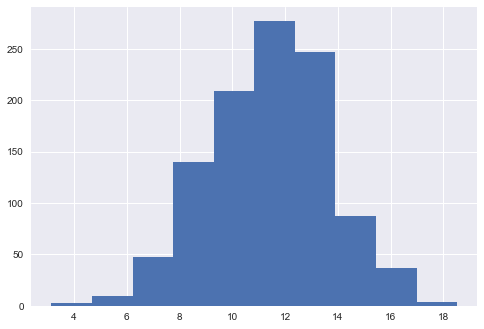

In [7]:
# log normal distribution
df['log_production'].hist()

In [9]:
df.Mine_Status.unique()

array(['Active, men working, not producing', 'Permanently abandoned',
       'Active', 'Temporarily closed', 'New, under construction'], dtype=object)

In [11]:
df[['Mine_Status', 'log_production']].groupby('Mine_Status').mean()

,log_production
Mine_Status,
Active,11.977453
"Active, men working, not producing",10.499962
"New, under construction",3.951244
Permanently abandoned,9.896046
Temporarily closed,9.162933


# predict the production of coal mines

In [13]:
for column in df.columns:
    print column

Year
Mine_Name
Mine_State
Mine_County
Mine_Status
Mine_Type
Company_Type
Operation_Type
Operating_Company
Operating_Company_Address
Union_Code
Coal_Supply_Region
Production_(short_tons)
Average_Employees
Labor_Hours
log_production


In [14]:
df.Union_Code.unique()

array([' ', 'UNIT', 'United Mine Workers of America', 'INTE',
       'International Union of Operation Engineers',
       'Scotia Employees Association', 'Western Energy Workers'], dtype=object)

In [15]:
df.Year.unique()

array([2013], dtype=int64)

In [17]:
features = ['Average_Employees',
            'Labor_Hours']

categorials = ['Mine_State',
               'Mine_County',
               'Mine_Status',
               'Mine_Type',
               'Company_Type',
               'Operation_Type',
               'Operating_Company',
               'Operating_Company_Address',
               'Union_Code',
               'Coal_Supply_Region']

target = 'log_production'

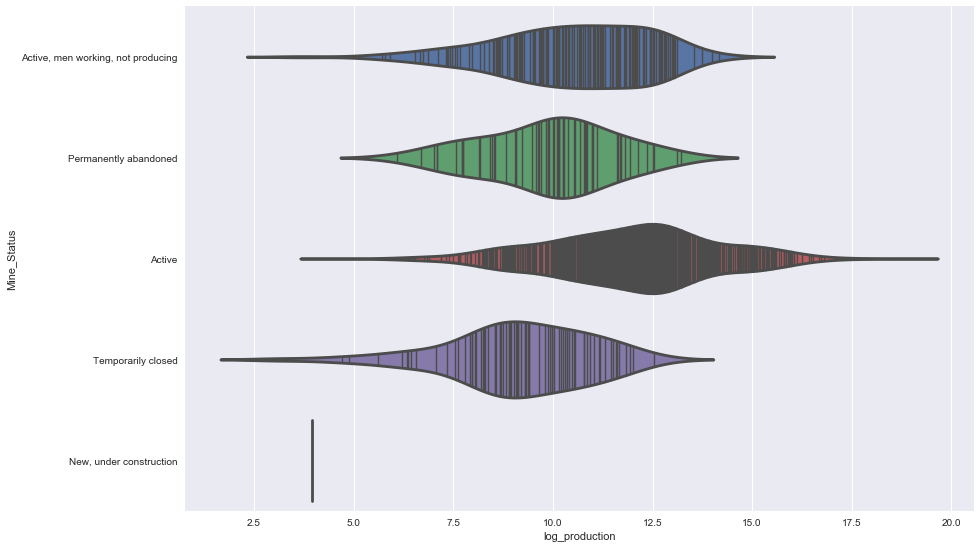

In [18]:
fig = plt.subplots(figsize=(14,8))
sns.set_context('poster')
sns.violinplot(y='Mine_Status', x="log_production", data=df, split=True, inner="stick");
plt.tight_layout()

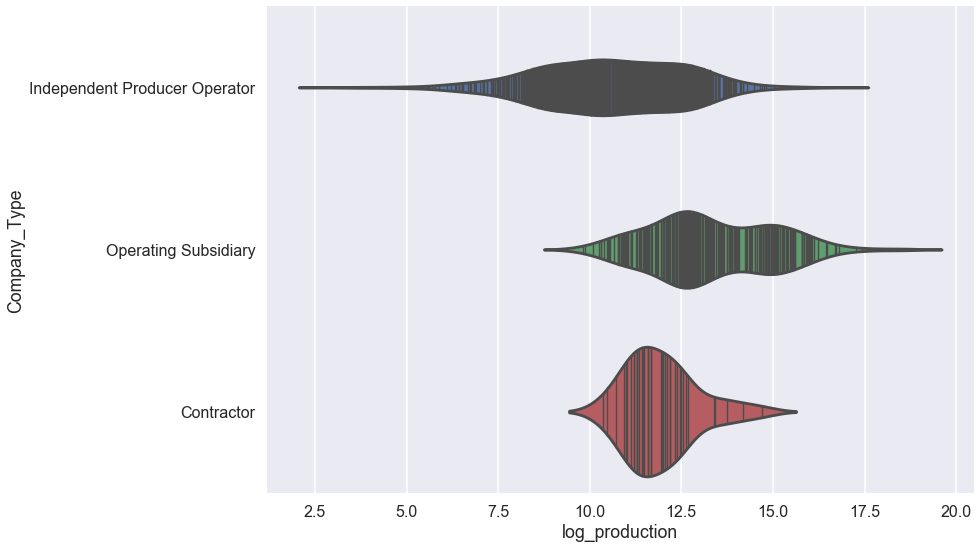

In [19]:
fig = plt.subplots(figsize=(14,8))
sns.set_context('poster')
sns.violinplot(y='Company_Type', x="log_production", data=df, split=True, inner="stick");
plt.tight_layout()

In [20]:
df.Company_Type.unique()

array(['Independent Producer Operator', 'Operating Subsidiary',
       'Contractor'], dtype=object)

In [24]:
pd.get_dummies(df.Company_Type).sample(50).head()

,Contractor,Independent Producer Operator,Operating Subsidiary
MSHA ID,,,
4407220,0,0,1
4103164,0,0,1
1518691,0,1,0
3609127,0,0,1
3608613,0,1,0


In [27]:
dummy_categoricals = []
for categorical in categorials:
    print categorical, len(df[categorical].unique())
    # avoid the dummy variable trap!
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    df = pd.concat([df, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

Mine_State 29
Mine_County 164
Mine_Status 5
Mine_Type 3
Company_Type 3
Operation_Type 2
Operating_Company 752
Operating_Company_Address 692
Union_Code 7
Coal_Supply_Region 8


In [28]:
dummy_categoricals[:10]

['Mine_State_Alabama',
 'Mine_State_Alaska',
 'Mine_State_Arizona',
 'Mine_State_Arkansas',
 'Mine_State_Colorado',
 'Mine_State_Illinois',
 'Mine_State_Indiana',
 'Mine_State_Kansas',
 'Mine_State_Kentucky (East)',
 'Mine_State_Kentucky (West)']

# build our model

In [29]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

C:\Anaconda2\envs\py2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
len(dummy_categoricals)

1655

In [32]:
train, test = train_test_split(df, test_size=0.3)

In [33]:
train.head()

,Year,Mine_Name,Mine_State,Mine_County,Mine_Status,Mine_Type,Company_Type,Operation_Type,Operating_Company,Operating_Company_Address,...,Union_Code_United Mine Workers of America,Union_Code_Western Energy Workers,Coal_Supply_Region_Appalachia Central,Coal_Supply_Region_Appalachia Northern,Coal_Supply_Region_Appalachia Southern,Coal_Supply_Region_Illinois Basin,Coal_Supply_Region_Interior,Coal_Supply_Region_Powder River Basin,Coal_Supply_Region_Uinta Region,Coal_Supply_Region_Western
MSHA ID,,,,,,,,,,,,,,,,,,,,,
3604186,2013,A W Long Coal Company,Pennsylvania (Bituminous),Clearfield,Active,Surface,Independent Producer Operator,Mine only,A W Long Coal Company,"154 Long Lane, Munson, PA 16860",...,0,0,0,1,0,0,0,0,0,0
1202316,2013,Freelandville Underground,Indiana,Knox,Permanently abandoned,Underground,Independent Producer Operator,Mine only,"Triad Underground Mining, L.L.","14972 East S.R. 58, Edwardsport, IN 47528",...,0,0,0,0,0,1,0,0,0,0
1519196,2013,#1,Kentucky (East),Pike,"Active, men working, not producing",Underground,Independent Producer Operator,Mine only,"Freedom Coal, Inc.","P.O. Box 249, Stanville, KY 41659",...,0,0,1,0,0,0,0,0,0,0
1202441,2013,Wild Boar Mine,Indiana,Warrick,Active,Surface,Operating Subsidiary,Mine only,"Peabody Wild Boar Mining, Llc","566 Dickeyville Rd., Lynnville, IN 47619",...,0,0,0,0,0,1,0,0,0,0
1518914,2013,Highwall Miner #1,Kentucky (East),Pike,Active,Surface,Contractor,Mine only,"Jrc Mining, Inc","P.O. Box 952, Hyden, KY 41749",...,0,0,1,0,0,0,0,0,0,0


In [35]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)

In [36]:
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

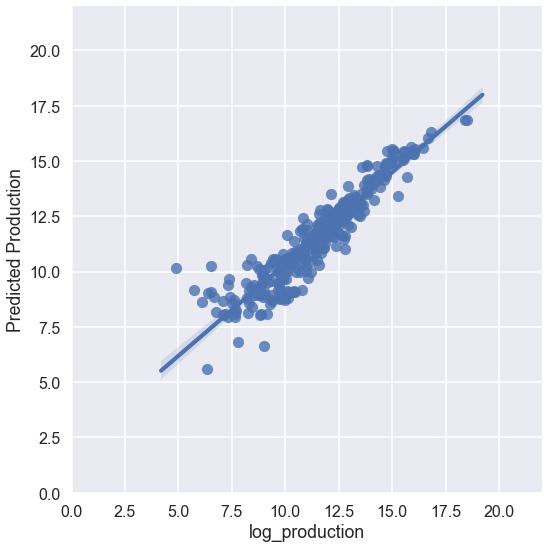

In [38]:
fig = plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]))
plt.ylabel('Predicted Production')
plt.xlim(0,22)
plt.ylim(0,22)
plt.tight_layout()

In [39]:
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

In [41]:
predicted = rf.predict(test[features + dummy_categoricals])
r2_score(test[target], predicted)

0.86404149543573749

In [42]:
explained_variance_score(test[target], predicted)

0.86510393552390252

In [43]:
mean_squared_error(test[target], predicted)

0.73959524396895193

In [44]:
rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns, 
                               'importance':rf.feature_importances_
                             }).sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_importances.head(20)

,importance,name
0,0.835921,Labor_Hours
1,0.056142,Average_Employees
2,0.006887,Mine_Type_Surface
3,0.005849,Coal_Supply_Region_Powder River Basin
4,0.003486,Coal_Supply_Region_Illinois Basin
5,0.002567,Coal_Supply_Region_Appalachia Central
6,0.002179,"Operating_Company_Address_P.O. Box 5, Van, WV ..."
7,0.002119,Mine_Status_Active
8,0.001933,"Operating_Company_West Fork Coal, Llc"
9,0.001843,Company_Type_Independent Producer Operator
